In [1]:
import torch
import webrtcvad
from io import BytesIO
import numpy as np

import matplotlib.pyplot as plt

import contextlib
import wave
from pydub import AudioSegment

from demo_model import ModelGRU
from demo_utils import restore_model
from demo_dataset import LibriSpeechActivityDataset

import IPython.display
%matplotlib inline

In [2]:
def read_file(path):
    flac = AudioSegment.from_file(path, 'flac')
    stream = BytesIO()
    flac.export(stream, format='wav')

    with contextlib.closing(wave.open(stream, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

In [3]:
device = torch.device('cpu')

model = ModelGRU(2, rnn_dim=64)
model.to(device)
restore_model(model)

eval_dataset = LibriSpeechActivityDataset('dummy_dataset.csv', '.', n_mels=128)

In [4]:
threshold = 0.5
batch, labels, waveform, fn = eval_dataset[0]
batch = batch.to(device)
labels = labels.to(device)
with torch.no_grad():
    out = model(batch)
    preds = (torch.softmax(out, dim=1)[:, 1] > threshold).int().cpu().numpy()
waveform = waveform.numpy()[0]
labels = labels.numpy()

In [5]:
IPython.display.Audio(data=waveform, rate=16000)

In [6]:
vad = webrtcvad.Vad(1)
data, sr = read_file(fn+'.flac')
activity = []
for i in range(0, len(data)//320):
    act = int(vad.is_speech(data[i*320:i*320+320],sr))
    for _ in range(320//2):
        activity.append(act)

audio_as_np_int16 = np.frombuffer(data, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

audio_normalised = audio_as_np_float32 / np.iinfo(np.int16).max
audio_max = audio_normalised.max()
activity_normalised = [el*audio_max for el in activity]

In [7]:
activity = [audio_max*el for el in preds for _ in range(160)]
labels_extd = [audio_max*el for el in labels for _ in range(160)]

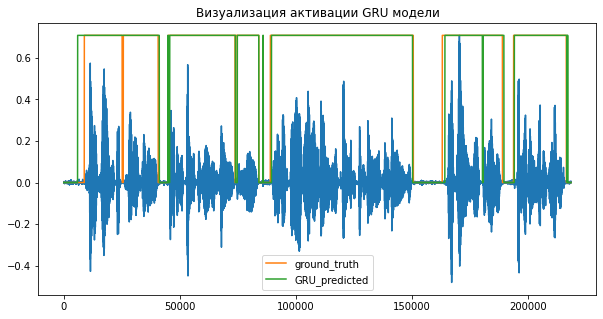

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(waveform)
ax.plot(labels_extd, label='ground_truth')
ax.plot(activity, label='GRU_predicted')
ax.legend()
ax.set_title('Визуализация активации GRU модели');

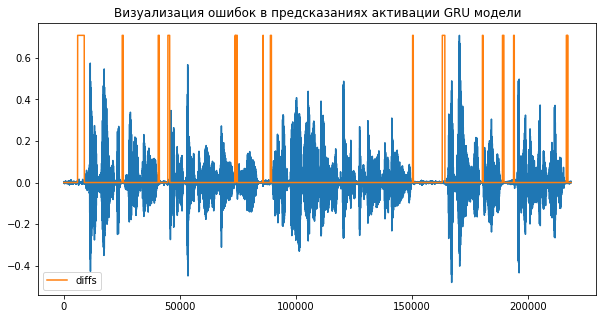

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(waveform)
ax.plot([abs(i-j) for i, j in zip(activity,labels_extd)], label='diffs')
ax.legend()
ax.set_title('Визуализация ошибок в предсказаниях активации GRU модели');

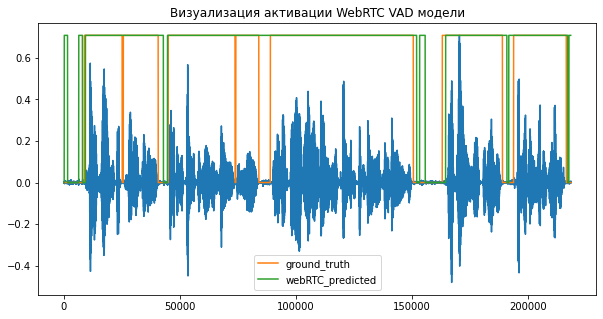

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(waveform)
ax.plot(labels_extd, label='ground_truth')
ax.plot(activity_normalised, label='webRTC_predicted')
ax.legend()
ax.set_title('Визуализация активации WebRTC VAD модели');

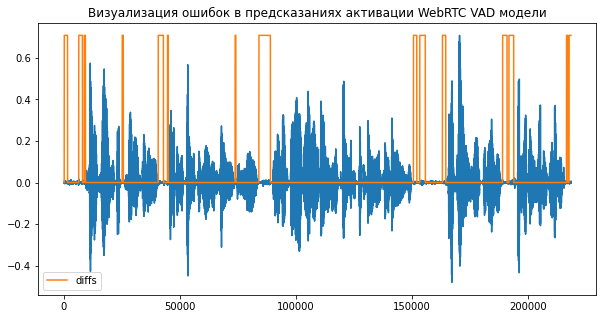

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(waveform)
ax.plot([abs(i-j) for i, j in zip(activity_normalised,labels_extd)], label='diffs')
ax.legend()
ax.set_title('Визуализация ошибок в предсказаниях активации WebRTC VAD модели');